In [44]:
from src.capstone.evaluation import Evaluator
from src.capstone.cbf import CBF, InfeasibilityError
from src.capstone.settings import Env

from double_integrator import DoubleIntegratorEnv
import gymnasium as gym

from bound_propagation.polynomial import Pow
from bound_propagation.linear import FixedLinear

import numpy as np

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from tqdm import tqdm 

$$B = \begin{bmatrix}
\frac{1}{2}\Delta t^2 & 0\\
0 & \frac{1}{2}\Delta t^2\\
\Delta t & 0\\
0 & \Delta t
\end{bmatrix}$$

$$Q = B B^T = \begin{bmatrix}
\frac{1}{2}\Delta t^2 & 0\\
0 & \frac{1}{2}\Delta t^2\\
\Delta t & 0\\
0 & \Delta t
\end{bmatrix} 

\begin{bmatrix}
\frac{1}{2}\Delta t^2 & 0 & \Delta t & 0\\
0 & \frac{1}{2}\Delta t^2 & 0 & \Delta t
\end{bmatrix} 

= \begin{bmatrix}
\frac{1}{4}\Delta t^4 & 0 & \frac{1}{2}\Delta t^3 & 0\\
0 & \frac{1}{4}\Delta t^4 & 0 & \frac{1}{2}\Delta t^3\\
\frac{1}{2}\Delta t^3 & 0 & \Delta t^2 & 0\\
0 & \frac{1}{2}\Delta t^3 & 0 & \Delta t^2
\end{bmatrix}$$

In [45]:
class IntegratorNoise(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        
        dt = 0.05
        self.cov = np.array([[0.25 * dt**4, 0., 0.5 * dt**3, 0.],
                           [0., 0.25 * dt**4, 0., 0.5 * dt**3],
                           [0.5 * dt**3, 0., dt**2, 0.],
                           [0., 0.5 * dt**3, 0., dt**2]])
        
    def step(self, action):
        state, _, _, truncated, _ = self.env.step(action)
        noise = np.random.multivariate_normal(mean=np.zeros(4), cov=self.cov)
        
        return (state + noise).astype(np.float32), 0., False, truncated, {}
    
    def reset(self, seed=None):
        return self.env.reset(seed=seed)

In [46]:
class NNDM(nn.Sequential):
    # input [x pos, y pos, x speed, y speed, ux, uy]
    
    def __init__(self):
        super(NNDM, self).__init__()
        self.dt = 0.05
        
        layer = nn.Linear(6, 4, bias=False)
        weights = torch.tensor([[1., 0., self.dt, 0., ((self.dt**2)/2), 0], 
                                [0., 1., 0., self.dt, 0., ((self.dt**2)/2)], 
                                [0., 0., 1., 0., self.dt, 0.], 
                                [0., 0., 0., 1., 0., self.dt]])
        layer.weight = nn.Parameter(weights)
        
        super(NNDM, self).__init__(layer)

nndm = NNDM()

In [47]:
class Agent(nn.Module):
    def __init__(self):
        super(Agent, self).__init__()
        
        self.layer = nn.Linear(2, 2)
        
        # dummy output of u=0
        self.layer.weight = nn.Parameter(torch.tensor([[0., 0., 0., 0.], [0., 0., 0., 0.]]))
        self.layer.bias = nn.Parameter(torch.tensor([50., 0.]))
    
    def forward(self, x):
        return self.layer(x)
    
    def select_action(self, x, exploration=False):
        if exploration:
            raise ValueError('This model is not implemented for exploration')
        else:
            return self.forward(x)

In [48]:
policy = Agent()

In [49]:
gym.register('DoubleIntegrator', DoubleIntegratorEnv, max_episode_steps=100)

In [50]:
class DoubleIntegrator(Env):
    def __init__(self):
        env = gym.make('DoubleIntegrator')
        
        self.is_discrete = False
        
        self.settings = {
            'noise': [],
            'max_frames': 999
        }
        
        self.h_function = nn.Sequential(
            FixedLinear(
                torch.tensor([
                    [1., 0, 0, 0],
                    [0, 1, 0, 0]
                ]),
                torch.tensor([0., 0.])
            ),
            Pow(2),
            FixedLinear(
                torch.tensor([
                    [-1 / 0.5 ** 2, 0],
                    [0, -1 / 0.5 ** 2]
                ]),
                torch.tensor([1., 1.])
            )
        )

        self.h_ids = [0, 1]
        self.std = [0.05**2/2, 0.05**2/2]
        self.env = IntegratorNoise(env)

In [51]:
env = DoubleIntegrator()

In [52]:
action = [50., 0.]


In [53]:
cbf = CBF(env, nndm, policy,
          alpha=[0.9875, 0.9875],
          delta=[0., 0.],
          no_action_partitions=5,
          no_noise_partitions=5,
          stochastic=True)

In [54]:
evaluator = Evaluator(env, cbf)
f, h = evaluator.mc_simulate(policy, 10, cbf_enabled=True, seed=[0., 0., 0., 0.])

 20%|██        | 2/10 [00:19<01:17,  9.63s/it]


KeyboardInterrupt: 

In [57]:
def plot_trajectories(num_agents, start_state, cbf_enabled=False):
    # plot the trajectories of the system, starting from the origin

    if start_state is None:
        start_state = [0., 0., 0., 0.]
    states = []

    for _ in tqdm(range(num_agents)):
        state_list = []
        state, _ = env.env.reset(seed=start_state)
        state = torch.tensor(state).unsqueeze(0)

        done = False

        while not done:   
            state_list.append(state.squeeze())

            # try cbf action - if cbf disabled or no safe actions available, just follow agent policy
            if cbf_enabled:
                try:
                    action = cbf.safe_action(state)
                except InfeasibilityError:
                    terminated = True
                    done = True
                    break
            else:
                action = policy.select_action(state, exploration=False)

            state, reward, terminated, truncated, _ = env.env.step(action.squeeze().detach().numpy())
            state = torch.tensor(state).unsqueeze(0)

            if torch.any(env.h_function(state.unsqueeze(0)) < 0).item():
                terminated = True

            done = terminated or truncated

        states.append(np.array(state_list))

    env.env.close()
    
    
    x_circle = np.linspace(-0.5, 0.5, 1001)
    
    y_circle_upper = [np.sqrt((0.5)**2 - x**2) for x in x_circle]
    y_circle_lower = [-np.sqrt((0.5)**2 - x**2) for x in x_circle]

    plt.plot(x_circle, y_circle_upper, color ="black")
    plt.plot(x_circle, y_circle_lower, color = "black")
    plt.fill_between(x_circle, y_circle_upper, y_circle_lower, color='g', alpha=0.3)
    x_axis = np.linspace(-0.5, 0.5, 3)
    y_axis = np.linspace(-0.5, 0.5, 3)

    plt.xticks(x_axis)
    plt.yticks(y_axis)

    plt.title("Trajectories")
    plt.xlabel("x")
    plt.ylabel("y")
    
    print(states)
    print(len(states))

    for trajectory in states:
        # https://stackoverflow.com/questions/21519203/plotting-a-list-of-x-y-coordinates 
        x, y, x_dot, y_dot = zip(*trajectory)
        plt.plot(x, y, c='b', alpha=0.1)

    print(len(x))
    print(len(y))
    print(x)
    print(y)

    plt.savefig("Double_integrator_trajectory_plot.png")
    plt.show()



100%|██████████| 10/10 [01:25<00:00,  8.53s/it]

[array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 4.82184440e-02,  2.82313376e-05,  1.92873764e+00,
         1.12925470e-03],
       [ 7.39837587e-02, -2.19725375e-03, -9.67701912e-01,
        -8.78901556e-02],
       [ 8.97616446e-02,  1.01440516e-03,  1.53440499e+00,
         4.05761972e-02],
       [ 1.04893357e-01, -6.06687390e-04, -9.89335358e-01,
        -2.42675208e-02],
       [ 1.17418349e-01,  2.82693072e-04,  1.48250484e+00,
         1.13951834e-02],
       [ 1.28999338e-01,  1.22333702e-04, -1.08341479e+00,
         5.06826816e-03],
       [ 1.39402539e-01,  2.11951765e-03,  1.43707061e+00,
         8.50543529e-02],
       [ 1.47853225e-01,  8.15782289e-04, -1.12054420e+00,
         3.30036730e-02],
       [ 1.56238079e-01, -1.76681962e-04,  1.41177344e+00,
        -6.58928277e-03],
       [ 1.62705362e-01,  2.20265076e-03, -1.13261175e+00,
         8.86896551e-02],
       [ 1.68753177e-01, -4.65878693e-04,  1.38155031e+00,
     

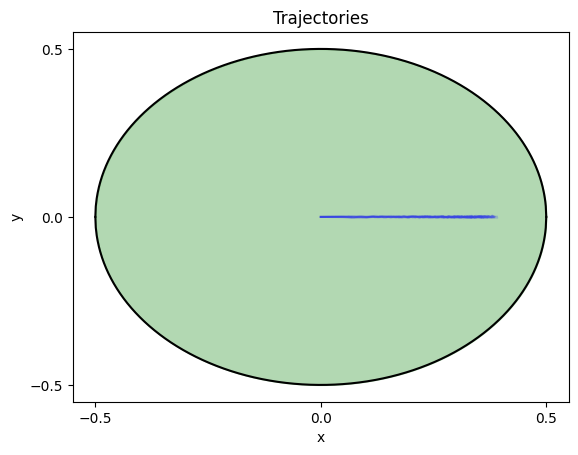

In [56]:
plot_trajectories(10, [0., 0., 0., 0.], cbf_enabled=True)